# Amazon Fine Food Review Analysis-Applying KNN with Brute-force algorithm
Objective: Given a review,determine whether the given review is positive or negative by applying KNN algorithm and deciding the best Feature generation technique for given problem. In order to load the data we have used SQLite dataset as it easier to query the data and visualise the data efficiently. Feature generation techniques to convert text to vector are Bow,Tfidf,Average Tfidf-Word2vec and Weighted Tfidf-Word2vec

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

from tqdm import tqdm
import os

#Using SQLite table to read data
con = sqlite3.connect('database.sqlite')

#filtering only positive and negative reviews and not taking reviews with score=3
filtered_data=pd.read_sql_query(""" Select * from Reviews Where Score!=3""",con)

#give reviews with score>3 as positive rating and score<3 as negative rating
def partition(x):
    if x<3:
        return 0
    return 1
actualScore = filtered_data['Score']

#changing reviews with score as positve and negative ratings 
positiveNegative= actualScore.map(partition)
filtered_data['Score']= positiveNegative
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [2]:
filtered_data.shape #looking at the number of attributes and size of the data

(525814, 10)

# Exploratory Data Analysis
Data Cleaning:Deduplication It is observed that the reviews data had many duplicate entries.Hence it is necessary to remove duplicate entries inorder to unbaised results for the analysis of data.

In [3]:
display = pd.read_sql_query("""select * from Reviews where Score!=3 and Userid="AR5J8UI46CURR" ORDER BY ProductId""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As observed that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text on doing the analysis.

In [4]:
#Sorting data according to ProductId in ascending order
sortedData=filtered_data.sort_values('ProductId',axis=0,kind="quicksort",ascending=True,inplace=False,na_position='last')

In [5]:
#Deduplication of entries
final=sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final.shape

(364173, 10)

In [6]:
final['Score'].value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [8]:
final=final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

Randomly selecting 100k data points.

In [14]:
#As data is huge,randomly selecting data from positive and negative reviews.
#final_pos = final[final.Score == 'positive'].sample(n=30000)
#final_neg = final[final.Score == 'negative'].sample(n=30000)
#concating both positive and negative review data
#final_60k = pd.concat([final_pos,final_neg],axis=0)
#randomly selecting 100000 data points
final_100k = final.sample(100000)
final_100k.shape
final_100k.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
161635,175228,B002EDGYN8,AVICQVASIHDHE,S. Vicente,0,0,1,1301011200,Yum!,Who'd a thunk it? This type of coconut cookie...
163537,177309,B002ZQ7B0O,A19LJC0CMXNLE4,Andrew S. Green,0,1,1,1271376000,Tasty Om nom,I had this candy after a dinner at a Thai rest...
99895,108508,B0030VBQGS,AUD46AGPGEPT9,careful shopper,0,0,1,1332720000,not just baby food -great for quick use in kit...,Too expensive for us to purchase at full price...


In [16]:
#sorting data by timestamp for time based slicing.
final_100k = final_100k.sort_values('Time',kind="quicksort")
final_100k.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...


In [17]:
final_100k['Score'].value_counts()

1    84270
0    15730
Name: Score, dtype: int64

Observation:It is an imbalanced dataset contains 84270 positive reviews and 15730 negative reviews

# Text Preprocessing:Stemming,Stop-words removal and Lemmatization

 1.Begin by removing html tags
 2.Remove any punctuations or set of any special characters
 3.Check if the word is made up of english letters and is not alpha-numeric
 4.Convert the word to lowercase
 5.Remove Stopwords
 6.Finally snowball stemming the word   

In [18]:
#find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if(len(re.findall('<.*?>',sent))):
        print(i)
        print(sent)
        break
    i += 1

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [19]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop= set(stopwords.words('english'))#set of stopwords
sno=nltk.stem.SnowballStemmer('english')#initializing the snowball stemmer
def cleanhtml(sentence):#function to clean the word of any html tag
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,' ',sentence)
    return cleantext
def cleanpunc(sentence):#function to clean any punctuation or special characters
    cleaned=re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned=re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
print(stop)
print('*******************************************')
print(sno.stem('tasty'))

{'off', 'own', 'or', 'is', 'i', 'how', 'other', 'too', 'yours', 'd', 'he', "mustn't", 'from', 'while', 'ma', 'doing', 'over', 'ain', 'of', "couldn't", 'nor', 'what', "hadn't", "you'd", 'itself', 'do', 'during', 'below', 're', "doesn't", "you're", 'shouldn', 'once', 'it', 'then', 'having', 'when', 'same', 'not', 'out', 'will', 't', 'wouldn', 'again', 'into', 'yourselves', 'with', 'any', "hasn't", 'few', 'her', 'down', "mightn't", 'them', 'weren', 'don', 'these', 'than', 'themselves', 'been', 'now', 'so', 'm', 'has', 'theirs', 'o', 'but', 'each', 'a', "wouldn't", 'between', 'my', 'further', 'doesn', 'whom', 've', 'couldn', 'being', "don't", 'which', 'your', 'mustn', 'him', 'both', 'should', 'hadn', "you'll", 'the', 'am', 'all', "she's", 'be', 'why', 'that', 'are', 'up', 'very', 'by', "that'll", 'shan', 'have', 'y', 'ourselves', 'was', "it's", 'those', 'here', 'before', 'there', 'more', 'where', 'only', 's', 'can', 'their', 'ours', 'had', 'myself', 'isn', "shan't", 'in', 'were', "wasn't",

In [20]:
#code for implementing step-by-step the checks mentioned the pre-processing phase    
str1=' '
final_string=[]
s=''
for i,sent in enumerate(tqdm(final_100k['Text'].values)):
    filtered_sentence=[]
    #print(sent);\n",
    sent=cleanhtml(sent) # remove HTMl tags\n",
    for w in sent.split():
          for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue 
    #print(filtered_sentence)\n",
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print(\"***********************************************************************\")\n",
    final_string.append(str1)
    i+=1
final_100k['CleanedText']=final_string #final string of cleaned words storing in a column of cleanedtext
final_100k['CleanedText']=final_100k['CleanedText'].str.decode("utf-8")

100%|█████████████████████████████████| 100000/100000 [07:45<00:00, 215.01it/s]


In [22]:
final_100k.shape

(100000, 11)

# Feature generation techniques to convert text to vector
Applying KNN with BOW

In [23]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
#splitting data into train and test where 70% data used for train model and 30% for test model
X = final_100k['CleanedText']
print("shape of X:",X.shape)
y = final_100k['Score']
print("shape of y:",y.shape)
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X,y,test_size=0.3,random_state=42)
print(X_train_bow.shape, y_train_bow.shape, X_test_bow.shape)

shape of X: (100000,)
shape of y: (100000,)
(70000,) (70000,) (30000,)


In [24]:
#generating BOW vector matrix for X_train text reviews
count_vect_bow=CountVectorizer()
X_train_bow = count_vect_bow.fit_transform(X_train_bow)
print("the type of count vectorizer",type(X_train_bow))
print("the shape of BOW vectorizer",X_train_bow.get_shape())
print("the number of unique words",X_train_bow.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer (70000, 31990)
the number of unique words 31990


In [25]:
#generating BOW vector matrix for X_test text reviews
#count_vect_bow=CountVectorizer()
X_test_bow = count_vect_bow.transform(X_test_bow)
print("the type of count vectorizer",type(X_test_bow))
print("the shape of BOW vectorizer",X_test_bow.get_shape())
print("the number of unique words",X_test_bow.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer (30000, 31990)
the number of unique words 31990


In [26]:
from sklearn.decomposition import TruncatedSVD

svd_model=TruncatedSVD(algorithm='randomized', n_components=300, n_iter=5, random_state=0, tol=0.0)
X_train_bow_trun = svd_model.fit_transform(X_train_bow)
print(svd_model.explained_variance_ratio_.sum())
X_test_bow_trun = svd_model.fit_transform(X_test_bow)
print(svd_model.explained_variance_ratio_.sum())

0.6269677183457221
0.6446726797095791


# KNN with Brute-force algorithm

In [27]:
#performing 10 fold cross validation method
#creating odd list of K for NN
#defining function to compute best optimal_k
def optimal_k_brute(X_train, y_train, myList):
    
    neighbors = list(filter(lambda x: x%2 != 0, myList))
    #empty list that will hold cv scores
    cv_scores = []

    #perform 10-fold cross validation
    for k in neighbors: 
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
    
    #changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    #determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print("\nThe optimal number of neighbors is %d" %optimal_k)

    #plot misclassification error vs k
    plt.plot(neighbors, MSE)
    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate("(%s,%s)" %xy, xy=xy, textcoords='data')
    plt.title("K vs Misclassification")
    plt.xlabel('Number of neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()
    print("the misclassification error for each k value is:",np.round(MSE,3))
    return optimal_k


As observed that for 10 fold cross validation splitting data into train and test as 70% and 30%.Applying KNN with Brute-force algorithm(for finding best k from 1 to 40) for train data and tested it using test data, evaluating accuracy with test data. 


The optimal number of neighbors is 15


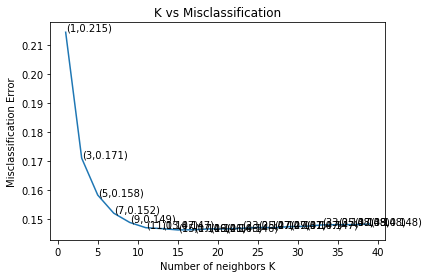

the misclassification error for each k value is: [0.215 0.171 0.158 0.152 0.149 0.147 0.147 0.146 0.146 0.146 0.146 0.147
 0.147 0.147 0.147 0.147 0.148 0.148 0.148 0.148]


In [28]:
#finding the optimal k by 10 fold cross validation
myList = list(range(0,40))
optimal_k_bow = optimal_k_brute(X_train_bow_trun, y_train_bow, myList)

Misclassification error is decreasing for each k value increasing and the optimal k value = 15

In [29]:
#instantiate learning model k = optimal_k
knn=KNeighborsClassifier(n_neighbors=optimal_k_bow)
knn.fit(X_train_bow_trun, y_train_bow) #fitting the model
pred = knn.predict(X_test_bow_trun) #predicting the response

In [30]:
#Accuracy on train data
train_acc_score = knn.score(X_train_bow_trun,y_train_bow)
print("Train accuracy",train_acc_score)

#Error on Train data
train_error = 1-(train_acc_score)
print("Train error ",train_error)

Train accuracy 0.8659714285714286
Train error  0.13402857142857139


In [31]:
#Evaluate accuracy on test data
print("Accuracy for KNN model with bag of words is", round(accuracy_score(y_test_bow, pred),3))

Accuracy for KNN model with bag of words is 0.83


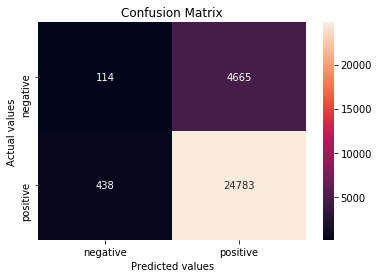

In [32]:
#Confusion Matrix
cm = confusion_matrix(y_test_bow, pred)

#Plotting confusion matrix
class_label = ["negative","positive"]
dataframe_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(dataframe_cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

In above confusion matrix tn(true negative)=114,tp(true positive)=24783,fn(false negative)=4665,fp(false positive)=438.As it is shown in classification report overall occuracy(correctly classified points)=(tp+tn)/total=(24783+114)/30000 = ~83%
overall error rate/misclassification rate=(fn+fp)/total=(4665+438)/30000 = ~17%.


In [33]:
#Classification report
print("classification report:")
print("**********************")
print(classification_report(y_test_bow,pred))

classification report:
**********************
             precision    recall  f1-score   support

          0       0.21      0.02      0.04      4779
          1       0.84      0.98      0.91     25221

avg / total       0.74      0.83      0.77     30000



Observed that the accuracy for KNN model with bag of words is 82.9%

# Feature generation techniques to convert text to vector
Applying KNN with TF-IDF 

In [34]:
#splitting data into train and test where 70% data used for train model and 30% for test model
X = final_100k['CleanedText']
print("shape of X:",X.shape)
y = final_100k['Score']
print("shape of y:",y.shape)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X,y,test_size=0.3,random_state=0)
print(X_train_tfidf.shape, y_train_tfidf.shape, X_test_tfidf.shape)

shape of X: (100000,)
shape of y: (100000,)
(70000,) (70000,) (30000,)


In [35]:
#TF-IDF train data
tfidf_vect = TfidfVectorizer()
X_train_tfidf=tfidf_vect.fit_transform(X_train_tfidf)
print("the type of tfidf vectorier",type(X_train_tfidf))
print("the shape of tfidf vetorizer",X_train_tfidf.get_shape()) 

the type of tfidf vectorier <class 'scipy.sparse.csr.csr_matrix'>
the shape of tfidf vetorizer (70000, 32022)


In [36]:
#TF-IDF test data 
tfidf_vect = TfidfVectorizer()
X_test_tfidf=tfidf_vect.fit_transform(X_test_tfidf)
print("the type of tfidf vectorier",type(X_test_tfidf))
print("the shape of tfidf vetorizer",X_test_tfidf.get_shape()) 

the type of tfidf vectorier <class 'scipy.sparse.csr.csr_matrix'>
the shape of tfidf vetorizer (30000, 21910)


In [37]:
from sklearn.decomposition import TruncatedSVD

svd_model=TruncatedSVD(algorithm='randomized', n_components=300, n_iter=5, random_state=0, tol=0.0)
X_train_tfidf_trun = svd_model.fit_transform(X_train_tfidf)
print(svd_model.explained_variance_ratio_.sum())
X_test_tfidf_trun = svd_model.fit_transform(X_test_tfidf)
print(svd_model.explained_variance_ratio_.sum())

0.3815103809163295
0.3873022353182216



The optimal number of neighbors is 27


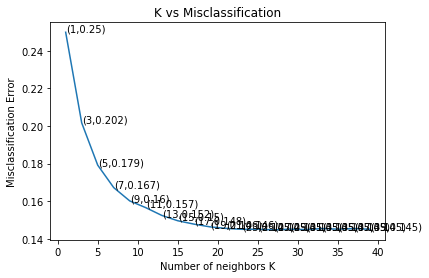

the misclassification error for each k value is: [0.25  0.202 0.179 0.167 0.16  0.157 0.152 0.15  0.148 0.146 0.146 0.145
 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145]


In [38]:
#finding the optimal k by 10 fold cross validation
myList = list(range(0,40))
optimal_k_tfidf = optimal_k_brute(X_train_tfidf_trun, y_train_tfidf, myList)

Misclassification error is decreasing for each k value increasing and the optimal k value = 27

In [39]:
#instantiate learning model k = optimal_k
knn=KNeighborsClassifier(n_neighbors=optimal_k_tfidf)
knn.fit(X_train_tfidf_trun, y_train_tfidf) #fitting the model
pred = knn.predict(X_test_tfidf_trun) #predicting the response

In [40]:
%%time
#Accuracy on train data
train_acc_score = knn.score(X_train_tfidf_trun,y_train_tfidf)
print("Train accuracy",train_acc_score)

#Error on Train data
train_error = 1-(train_acc_score)
print("Train error ",train_error)

Train accuracy 0.8635857142857143
Train error  0.1364142857142857
Wall time: 3h 2min 53s


In [41]:
#Evaluate accuracy on test data
print("Accuracy for KNN model with tfidf is", round(accuracy_score(y_test_tfidf, pred),3))

Accuracy for KNN model with tfidf is 0.836


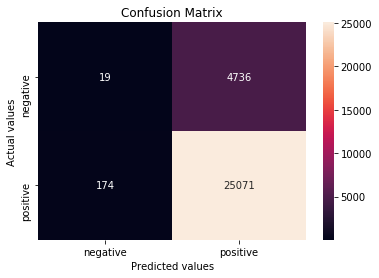

In [42]:
#Confusion Matrix
cm = confusion_matrix(y_test_tfidf, pred)

#Plotting confusion matrix
class_label = ["negative","positive"]
dataframe_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(dataframe_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

In above confusion matrix tn(true negative)=19,tp(true positive)=25071,fn(false negative)=4736,fp(false positive)=174.As it is shown in classification report overall occuracy(correctly classified points)=(tp+tn)/total=(25071+19)/30000 = ~83% overall error rate/misclassification rate=(fn+fp)/total=(4736+174)/30000 = ~16%.

In [43]:
#Classification report
print("classification report:")
print("**********************")
print(classification_report(y_test_tfidf,pred))

classification report:
**********************
             precision    recall  f1-score   support

          0       0.10      0.00      0.01      4755
          1       0.84      0.99      0.91     25245

avg / total       0.72      0.84      0.77     30000



Observed that the accuracy for KNN model with TF-IDF is 83.6%

# Feature generation techniques to convert text to vector
Applying KNN with TF-IDF Average Word2vec

In [42]:
#splitting data into train and test where 70% data used for train model and 30% for test model
X = final_100k['CleanedText']
print("shape of X:",X.shape)
y = final_100k['Score']
print("shape of y:",y.shape)
X_train_avgw2v, X_test_avgw2v, y_train_avgw2v, y_test_avgw2v = train_test_split(X,y,test_size=0.3,random_state=0)
print(X_train_avgw2v.shape, y_train_avgw2v.shape, X_test_avgw2v.shape)

shape of X: (100000,)
shape of y: (100000,)
(70000,) (70000,) (30000,)


In [43]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#Train your own word2vec model using your own text corpus of train data
import gensim
i=0
list_of_sent_train=[]
for sent in X_train_avgw2v:
    list_of_sent_train.append(sent.split())
print(list_of_sent_train[0])
print('**********************************')
print(list_of_sent_train[1])

['youv', 'cracker', 'alreadi', 'know', 'wonder', 'ive', 'gotten', 'cracker', 'packag', 'first', 'time', 'perfect', 'size', 'dont', 'use', 'often', 'keep', 'fresh', 'longer', 'open', 'full', 'size', 'box', 'receiv', 'aug', 'expir', 'date', 'april', 'next', 'year']
**********************************
['pretti', 'avid', 'whole', 'food', 'shopper', 'felt', 'pretti', 'good', 'purchas', 'organ', 'babi', 'food', 'month', 'old', 'son', 'earth', 'best', 'brand', 'popular', 'bought', 'teeth', 'biscuit', 'recent', 'today', 'could', 'die', 'eat', 'one', 'although', 'anesthesiologist', 'half', 'job', 'protect', 'peopl', 'airway', 'one', 'neednt', 'medic', 'profession', 'realiz', 'biscuit', 'danger', 'babi', 'get', 'front', 'teeth', 'upper', 'lower', 'incisor', 'first', 'long', 'molar', 'arriv', 'theyr', 'limit', 'bite', 'front', 'teeth', 'mash', 'gum', 'molar', 'someday', 'erupt', 'biscuit', 'great', 'first', 'minut', 'babi', 'happili', 'chomp', 'away', 'hard', 'surfac', 'soften', 'pretti', 'soon', 

In [44]:
#min_count=5 considers only the words occur atleast 5 times
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)
words=list(w2v_model.wv.vocab)
print("number of words that occured 5 times",len(words))

number of words that occured 5 times 10892


In [45]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times",len(w2v_words))
print("sample words",w2v_words[0:50])

number of words that occured minimum 5 times 10892
sample words ['youv', 'cracker', 'alreadi', 'know', 'wonder', 'ive', 'gotten', 'packag', 'first', 'time', 'perfect', 'size', 'dont', 'use', 'often', 'keep', 'fresh', 'longer', 'open', 'full', 'box', 'receiv', 'aug', 'expir', 'date', 'april', 'next', 'year', 'pretti', 'avid', 'whole', 'food', 'shopper', 'felt', 'good', 'purchas', 'organ', 'babi', 'month', 'old', 'son', 'earth', 'best', 'brand', 'popular', 'bought', 'teeth', 'biscuit', 'recent', 'today']


In [46]:
#average word2vec
#compute average word2vec for each review
sent_vectors_train=[];# the avg-w2v for each sentence/review is stored
for sent in tqdm(list_of_sent_train): #for each review/sentence
    sent_vec=np.zeros(50) #as word vectors are of zero length
    cnt_words=0  #number of words with a valid vector in the review/sentence
    for word in sent: #for each word in a review/sentence
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████| 70000/70000 [03:24<00:00, 342.62it/s]


70000
50


In [47]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#Train your own word2vec model using your own text corpus of train data
import gensim
i=0
list_of_sent_test=[]
for sent in X_test_avgw2v:
    list_of_sent_test.append(sent.split())
print(list_of_sent_test[0])
print('**********************************')
print(list_of_sent_test[1])

['love', 'noodl', 'look', 'forward', 'deliveri', 'hungri', 'need', 'someth', 'calm', 'crave', 'noodl', 'hit', 'spot', 'continu', 'order', 'long', 'time', 'come']
**********************************
['mapl', 'bake', 'bean', 'disappoint', 'mapl', 'flavor', 'besid', 'wateri', 'product', 'cook', 'long', 'enough', 'bean', 'still', 'hard', 'would', 'buy', 'could', 'recommend', 'anyon']


In [48]:
#min_count=5 considers only the words occur atleast 5 times
w2v_model=Word2Vec(list_of_sent_test,min_count=5,size=50,workers=4)
words=list(w2v_model.wv.vocab)
print("number of words that occured 5 times",len(words))

number of words that occured 5 times 7459


In [49]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times",len(w2v_words))
print("sample words",w2v_words[0:50])

number of words that occured minimum 5 times 7459
sample words ['love', 'noodl', 'look', 'forward', 'deliveri', 'hungri', 'need', 'someth', 'calm', 'crave', 'hit', 'spot', 'continu', 'order', 'long', 'time', 'come', 'mapl', 'bake', 'bean', 'disappoint', 'flavor', 'besid', 'wateri', 'product', 'cook', 'enough', 'still', 'hard', 'would', 'buy', 'could', 'recommend', 'anyon', 'toy', 'save', 'furnitur', 'instead', 'puppi', 'chew', 'usual', 'tire', 'day', 'one', 'month', 'first', 'goe', 'morn', 'last', 'play']


In [50]:
#average word2vec
#compute average word2vec for each review
sent_vectors_test=[];# the avg-w2v for each sentence/review is stored
for sent in tqdm(list_of_sent_test): #for each review/sentence
    sent_vec=np.zeros(50) #as word vectors are of zero length
    cnt_words=0  #number of words with a valid vector in the review/sentence
    for word in sent: #for each word in a review/sentence
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████| 30000/30000 [01:46<00:00, 282.28it/s]


30000
50


In [51]:
len(sent_vectors_train)

70000

In [52]:
len(sent_vectors_test)

30000


The optimal number of neighbors is 25


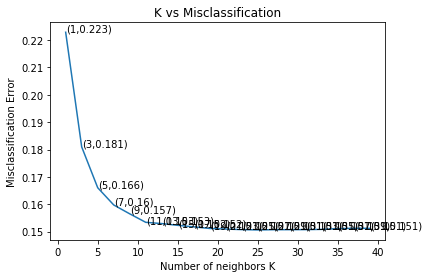

the misclassification error for each k value is: [0.223 0.181 0.166 0.16  0.157 0.153 0.153 0.152 0.152 0.151 0.151 0.151
 0.151 0.151 0.151 0.151 0.151 0.151 0.151 0.151]


In [53]:
X_train_avgw2v=sent_vectors_train
X_test_avgw2v=sent_vectors_test

#finding the optimal k by 10 fold cross validation
myList = list(range(0,40))
optimal_k_avgw2v = optimal_k_brute(X_train_avgw2v, y_train_avgw2v, myList)

Misclassification error is decreasing for each k value increasing and the optimal k value = 25

In [56]:
#instantiate learning model k = optimal_k
knn=KNeighborsClassifier(n_neighbors=optimal_k_avgw2v)
knn.fit(X_train_avgw2v, y_train_avgw2v) #fitting the model
pred = knn.predict(X_test_avgw2v) #predicting the response

In [57]:
#Accuracy on train data
train_acc_score = knn.score(X_train_avgw2v,y_train_avgw2v)
print("Train accuracy",train_acc_score)

#Error on Train data
train_error = 1-(train_acc_score)
print("Train error ",train_error)

Train accuracy 0.8524571428571428
Train error  0.1475428571428572


In [58]:
#Evaluate accuracy on test data
print("Accuracy for KNN model with Tfidf Average Word2vector is", round(accuracy_score(y_test_avgw2v, pred),3))

Accuracy for KNN model with Tfidf Average Word2vector is 0.844


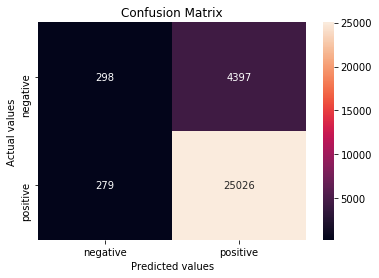

In [60]:
#Confusion Matrix
cm = confusion_matrix(y_test_avgw2v, pred)

#Plotting confusion matrix
class_label = ["negative","positive"]
dataframe_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(dataframe_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

In above confusion matrix tn(true negative)=298,tp(true positive)=25026,fn(false negative)=4397,fp(false positive)=279.As it is shown in classification report overall occuracy(correctly classified points)=(tp+tn)/total=(25026+298)/30000 = ~84% overall error rate/misclassification rate=(fn+fp)/total=(4397+279)/30000 = ~15%

In [61]:
#Classification report
print("classification report")
print("*********************")
print(classification_report(y_test_avgw2v,pred))

classification report
*********************
             precision    recall  f1-score   support

          0       0.52      0.06      0.11      4695
          1       0.85      0.99      0.91     25305

avg / total       0.80      0.84      0.79     30000



Observed that the accuracy for KNN model with TF-IDF Average Word2Vec is 84.4%

# Feature generation techniques to convert text to vector
Applying KNN with TF-IDF Weighted Word2vec

In [68]:
#splitting data into train and test where 70% data used for train model and 30% for test model
X = final_100k['CleanedText']
print("shape of X:",X.shape)
y = final_100k['Score']
print("shape of y:",y.shape)
X_train_wtdw2v, X_test_wtdw2v, y_train_wtdw2v, y_test_wtdw2v = train_test_split(X,y,test_size=0.3,random_state=0)
print(X_train_wtdw2v.shape, y_train_wtdw2v.shape, X_test_wtdw2v.shape)

shape of X: (100000,)
shape of y: (100000,)
(70000,) (70000,) (30000,)


In [69]:
model = TfidfVectorizer()
X_train_wtdw2v = model.fit_transform(X_train_wtdw2v)
#we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [70]:
model = TfidfVectorizer()
X_test_wtdw2v = model.fit_transform(X_test_wtdw2v)
#we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [72]:
#TF-IDF weighted word2vec
tfidf_feat=model.get_feature_names()
#tfidf words/col-names
#final_tf_idf is the sparse matrix with row=sentence,col=word and cell_val=tfidf
tfidf_sent_vectors_train=[]
row=0
for sent in tqdm(list_of_sent_train): #for each review/sentence
    sent_vec=np.zeros(50) #as word vectors are of zero length
    weight_sum=0  #num of words with a valid vector in the sentence/review
    for word in sent:   #for each word in a review/sentence
        if word in w2v_words:  
            vec=w2v_model.wv[word]#to reduce the computation we are
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))#dictionary[word] = idf value of word in whole corpus
            sent_vec += (vec*tf_idf) #sent.count(word)= tf values of word in this review
            weight_sum += tf_idf
    if weight_sum !=0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row +=1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|███████████████████████████████████| 70000/70000 [03:49<00:00, 304.65it/s]


70000
50


In [73]:
#TF-IDF weighted word2vec
tfidf_feat=model.get_feature_names()
#tfidf words/col-names
#final_tf_idf is the sparse matrix with row=sentence,col=word and cell_val=tfidf
tfidf_sent_vectors_test=[]
row=0
for sent in tqdm(list_of_sent_test): #for each review/sentence
    sent_vec=np.zeros(50) #as word vectors are of zero length
    weight_sum=0  #num of words with a valid vector in the sentence/review
    for word in sent:   #for each word in a review/sentence
        if word in w2v_words:  
            vec=w2v_model.wv[word]#to reduce the computation we are
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))#dictionary[word] = idf value of word in whole corpus
            sent_vec += (vec*tf_idf) #sent.count(word)= tf values of word in this review
            weight_sum += tf_idf
    if weight_sum !=0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row +=1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|███████████████████████████████████| 30000/30000 [01:44<00:00, 287.46it/s]


30000
50



The optimal number of neighbors is 15


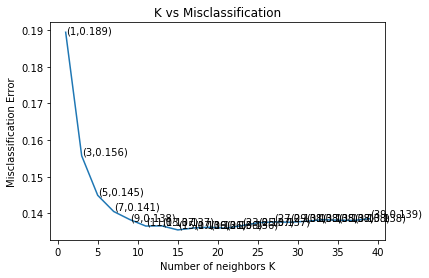

the misclassification error for each k value is: [0.189 0.156 0.145 0.141 0.138 0.137 0.137 0.136 0.136 0.136 0.136 0.137
 0.137 0.138 0.138 0.138 0.138 0.138 0.138 0.139]


In [74]:
X_train_wtdw2v=tfidf_sent_vectors_train
X_test_wtdw2v=tfidf_sent_vectors_test

#finding the optimal k by 10 fold cross validation
myList = list(range(0,40))
optimal_k_wtdw2v = optimal_k_brute(X_train_wtdw2v, y_train_wtdw2v, myList)

Misclassification error is decreasing for each k value increasing and the optimal k value = 15

In [75]:
#instantiate learning model k = optimal_k
knn=KNeighborsClassifier(n_neighbors=optimal_k_wtdw2v)
knn.fit(X_train_wtdw2v, y_train_wtdw2v) #fitting the model
pred = knn.predict(X_test_wtdw2v) #predicting the response

In [76]:
#Accuracy on train data
train_acc_score = knn.score(X_train_wtdw2v,y_train_wtdw2v)
print("Train accuracy",train_acc_score)

#Error on Train data
train_error = 1-(train_acc_score)
print("Train error ",train_error)

Train accuracy 0.8754142857142857
Train error  0.1245857142857143


In [77]:
#Evaluate accuracy on test data
print("Accuracy for KNN model with Tfidf Weighted Word2vector is", round(accuracy_score(y_test_wtdw2v, pred),3))

Accuracy for KNN model with Tfidf Weighted Word2vector is 0.866


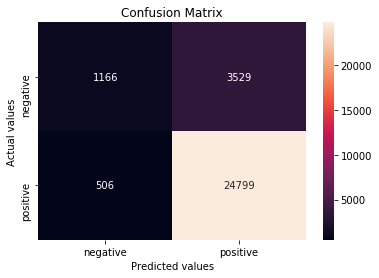

In [79]:
#Confusion Matrix
cm = confusion_matrix(y_test_wtdw2v, pred)

#Plotting confusion matrix
class_label = ["negative","positive"]
dataframe_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(dataframe_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

In above confusion matrix tn(true negative)=1166,tp(true positive)=24799,fn(false negative)=3529,fp(false positive)=506.As it is shown in classification report overall occuracy(correctly classified points)=(tp+tn)/total=(24799+1166)/30000 = ~86.5% overall error rate/misclassification rate=(fn+fp)/total=(3529+506)/30000 = ~13.4%

In [80]:
#Classification report
print("classification report")
print("*********************")
print(classification_report(y_test_wtdw2v,pred))

classification report
*********************
             precision    recall  f1-score   support

          0       0.70      0.25      0.37      4695
          1       0.88      0.98      0.92     25305

avg / total       0.85      0.87      0.84     30000



Observed that the accuracy for KNN model with TF-IDF Weighted Word2vec is 86.5%

In [44]:
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("Vectorizer",["Bag Of Words","TF-IDF","Average Word2vec","TF-IDF Weighted Word2vec"])
x.add_column("Model",['Brute','Brute','Brute','Brute'])
#x.add_column("Train Accuracy",['86%','86%','85%','87%'])
#x.add_column("Train Error",['13%','13%','14%','12%'])
x.add_column("Optimal K",[15,27,25,15])
x.add_column("Accuracy on Test Data",['83%','83%','84%','86%'])
print(x)

+--------------------------+-------+-----------+-----------------------+
|        Vectorizer        | Model | Optimal K | Accuracy on Test Data |
+--------------------------+-------+-----------+-----------------------+
|       Bag Of Words       | Brute |     15    |          83%          |
|          TF-IDF          | Brute |     27    |          83%          |
|     Average Word2vec     | Brute |     25    |          84%          |
| TF-IDF Weighted Word2vec | Brute |     15    |          86%          |
+--------------------------+-------+-----------+-----------------------+


Table shows for all four models Optimal value of k and test accuracy.

Observation:
    By comparing the accuracy of all the four feature generation techniques KNN model with TF-IDF Weighted Word2vec gives 86% of accuracy, which is the best accuracy to predict the polarity of reviews among all the models.